# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install scikit-learn==0.24.1

In [1]:
# import libraries here; add more as necessary
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter


from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pylab import *

from functions import *
from workspace import active_session

with open('selected_columns.pkl', 'rb') as f:
    selected_columns = pickle.load(f)

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 370)
pd.set_option('display.max_rows', 500)

In [3]:
attributes, attributes_info = read_and_standardize_attributes()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 36.9 s, sys: 42.6 s, total: 1min 19s
Wall time: 10min 47s


In [6]:
%%time
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 17 s, sys: 4.95 s, total: 21.9 s
Wall time: 3min 7s


In [7]:
headers_azdias = azdias.columns
headers_customers = customers.columns

In [8]:
#cheking attributes data
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


Filling this NaNs in attributes data to make it easier to deal later

In [9]:
attributes['Attribute'].ffill(inplace=True)
attributes['Meaning'].fillna('no description', inplace=True)
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


# Dealing with Warnings

Dealing with this wargnings:

"<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False."

In [10]:
warning_columns = list(azdias.columns[18:20])
warning_columns

['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

In [11]:
cameo_columns = [attribute for attribute in attributes['Attribute'].unique() if "CAMEO" in attribute]
cameo_columns

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015']

Now we have this name problem of the attribute not matching in dataframes.
Attribute CAMEO_INTL_2015 is named CAMEO_DEUINTL_2015 in the attributes excel

In [12]:
#Fixing Attribute Name
attributes_info['Attribute'] = attributes_info['Attribute'].replace("CAMEO_DEUINTL_2015", "CAMEO_INTL_2015")
attributes['Attribute'] = attributes['Attribute'].replace("CAMEO_DEUINTL_2015", "CAMEO_INTL_2015")

Looking in to the data what values are causing the problem

In [14]:
for column in warning_columns:
    values = azdias[column].unique()
    print(f" Column: {column}\n Unique Values: {list(values)}\n\n")

 Column: CAMEO_DEUG_2015
 Unique Values: [nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7', '2', '8', '9', '6', '5', '1', 'X']


 Column: CAMEO_INTL_2015
 Unique Values: [nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0, '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX']




Apparently we have strings with letters and numbers as strings

##### Fixing Warning Columns

In [16]:
%%time
azdias = fix_warning_cols(azdias)
customers = fix_warning_cols(customers)

CPU times: user 30.2 s, sys: 46.7 s, total: 1min 16s
Wall time: 15min 2s


Taking a look if the values where handled

In [17]:
for column in warning_columns:
    values = azdias[column].unique()
    print(f" Column: {column}\n Unique Values: {list(values)}\n\n")

 Column: CAMEO_DEUG_2015
 Unique Values: [nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0]


 Column: CAMEO_INTL_2015
 Unique Values: [nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0]




Apparently the problem in columns 18 and 19 were fixed, now we need to clean and standardize some data

## Cleaning and Standardizing

In [18]:
# Find common attributes in dataframes and saving if needs to run this multiple times
common_attributes = common_attributes_fc(azdias, customers, attributes)
with open('common_attributesr.pkl', 'wb') as f:
    pickle.dump(common_attributes, f)

It will be used only the attributes common to all datasets and the excell sheet

In [19]:
print(f"Azdias Total Attributes: {len(azdias.columns)}")
print(f"Customers Total Attributes: {len(customers.columns)}")
print(f"Attributes Data Total Attributes: {len(list(attributes['Attribute'].unique()))}")
print(f"Common Attributes: {len(common_attributes)}")

Azdias Total Attributes: 366
Customers Total Attributes: 369
Attributes Data Total Attributes: 314
Common Attributes: 273


In [20]:
# Setting attributes common to all
attributes = attributes[attributes['Attribute'].isin(common_attributes)]
azdias = azdias[common_attributes]
customers = customers[common_attributes]

In [21]:
print(f"Azdias Total Attributes: {len(azdias.columns)}")
print(f"Customers Total Attributes: {len(customers.columns)}")
print(f"Attributes Data Total Attributes: {len(list(attributes['Attribute'].unique()))}")

Azdias Total Attributes: 273
Customers Total Attributes: 273
Attributes Data Total Attributes: 273


### Unknown Values in attributes

Here we will take a look into values that have the possibilitie of 'unkown' value

In [22]:
attributes[attributes['Meaning'].str.contains('unknown')]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_INTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown
654,FINANZTYP,best descirbing financial type for the person,-1,unknown


In [23]:
#Setting unknown value to -1
att_mask = attributes['Value'] == '-1, 9'
attributes.loc[att_mask, 'Value'] = -1
    
att_mask2 = attributes['Value'] == '-1, 0'
attributes.loc[att_mask2, 'Value'] = -1

att_mask3 = ((attributes['Value'] == 10) | (attributes['Value'] == 0)) & attributes['Meaning'].str.contains('unknown')
attributes.loc[att_mask3, 'Value'] = -1

In [24]:
attributes[attributes['Meaning'].str.contains('unknown')]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,-1,unknown
11,ALTER_HH,main age within the household,-1,unknown / no main age detectable
33,ANREDE_KZ,gender,-1,unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_INTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,-1,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown
654,FINANZTYP,best descirbing financial type for the person,-1,unknown


#### Standardizing Data
Making values out of the attributes values to unknown values

In [27]:
%%time
azdias = standardize_dataset(azdias)
customers = standardize_dataset(customers)

CPU times: user 4.11 s, sys: 132 ms, total: 4.24 s
Wall time: 6.27 s


In [28]:
%%time
# Doing some feature engeneering and fixing birthdate column
azdias_adjusted = feature_engeneering(azdias.copy())
azdias_adjusted = label_categorical_to_numeric(azdias_adjusted)
azdias_adjusted = replace_unknown_values(azdias_adjusted)

Wealth Feature, ok!
Family Feature, ok!
Neighborhood Feature, ok!
Community Feature, ok!
Gender Feature, ok!
Life Stage Feature, ok!
Income Feature, ok!
Positioning(Mainstream vs Avantgarde) Feature, ok!
Fixing birthdate attribute - replacing zeros to NaNs
CPU times: user 22.9 s, sys: 1min 14s, total: 1min 37s
Wall time: 14min 55s


In [29]:
%%time
customers_adjusted = feature_engeneering(customers.copy())
customers_adjusted = label_categorical_to_numeric(customers_adjusted)
customers_adjusted = replace_unknown_values(customers_adjusted)

Wealth Feature, ok!
Family Feature, ok!
Neighborhood Feature, ok!
Community Feature, ok!
Gender Feature, ok!
Life Stage Feature, ok!
Income Feature, ok!
Positioning(Mainstream vs Avantgarde) Feature, ok!
Fixing birthdate attribute - replacing zeros to NaNs
CPU times: user 5.76 s, sys: 7.65 s, total: 13.4 s
Wall time: 5min 31s


In [88]:
%%time
with open('azdias_clean.pkl', 'rb') as f:
    azdias_adjusted = pickle.load(f)
    
with open('customers_clean.pkl', 'rb') as f:
    customers_adjusted = pickle.load(f)

CPU times: user 1.15 s, sys: 4.79 s, total: 5.95 s
Wall time: 3min 38s


#### Feature NaNs

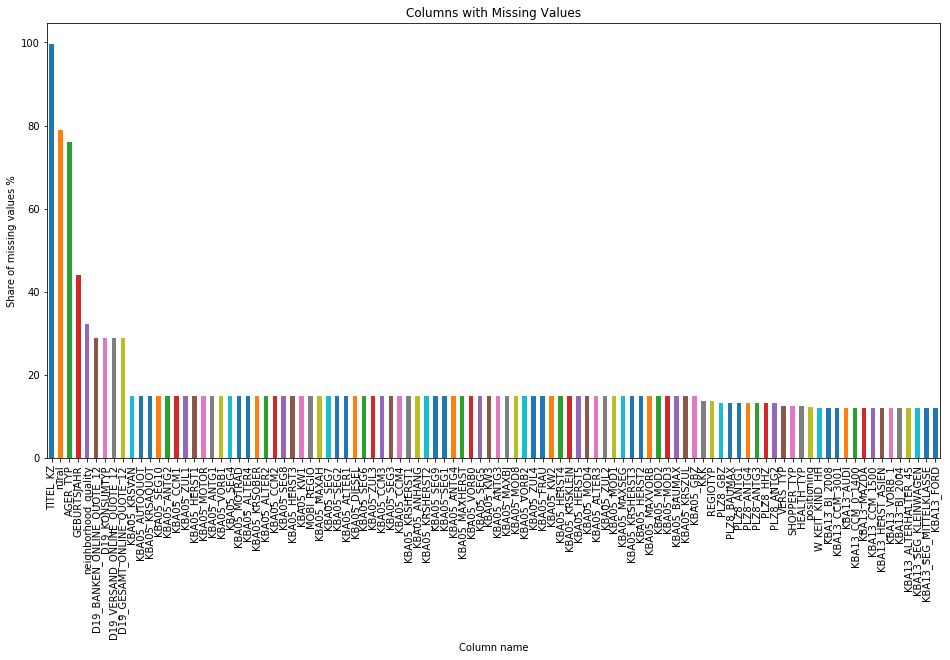

In [6]:
null_values = azdias_adjusted.isnull().sum().sort_values(ascending=False)
null_values = null_values / len(azdias_adjusted)
azdias_null_share = null_values * 100
azdias_null_share_plot = azdias_null_share[azdias_null_share > 0].copy()

# Plot 100 columns with highest share of missing values
fig = plt.figure()
ax = azdias_null_share_plot.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(16,8), title=f'Columns with Missing Values')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
ax = fig.add_subplot(ax)
fig.savefig('missingvalues.png',format='png',)

## Dropping Columns with missing values (> 35%)

In [7]:
selected_columns = azdias_null_share[azdias_null_share < 35].index

In [8]:
azdias_adjusted = azdias_adjusted[selected_columns]
customers_adjusted = customers_adjusted[selected_columns]

## Dealing with NaNs

In [15]:
# Fill NaNs with mode
for column in selected_columns:
    azdias_adjusted[column] = azdias_adjusted[column].replace(np.nan,azdias_adjusted[column].mode()[0])
    customers_adjusted[column] = customers_adjusted[column].replace(np.nan,customers_adjusted[column].mode()[0])

In [18]:
#Check NaNs
print("Dataframe total NaNs:")
print(f"Azdias - {azdias_adjusted.isnull().sum().sum()}")
print(f"Customers - {customers_adjusted.isnull().sum().sum()}")

Dataframe total NaNs:
Azdias - 0
Customers - 0


# Scalling

In [19]:
%%time
# Creating a scaler model to fit in all dataframes
azdias_scaler = MinMaxScaler()
azdias_scaler.fit(azdias_adjusted)
with open('azdias_scaler.pkl', 'wb') as f:
    pickle.dump(azdias_scaler, f)

CPU times: user 1.28 s, sys: 2.52 s, total: 3.8 s
Wall time: 54.9 s


Now it will be used a MinMaxScaler to run PCA

In [20]:
%%time
azdias_columns = azdias_adjusted.columns
azdias_scaled = pd.DataFrame(azdias_scaler.transform(azdias_adjusted))
azdias_scaled.columns = azdias_columns

CPU times: user 2.63 s, sys: 20.4 s, total: 23.1 s
Wall time: 4min 36s


In [26]:
azdias_scaled['OST_WEST_KZ']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
5         1.0
6         1.0
7         1.0
8         1.0
9         1.0
10        1.0
11        1.0
12        1.0
13        1.0
14        1.0
15        1.0
16        1.0
17        1.0
18        1.0
19        1.0
20        1.0
21        1.0
22        1.0
23        1.0
24        1.0
25        1.0
26        1.0
27        1.0
28        1.0
29        1.0
30        1.0
31        1.0
32        1.0
33        1.0
34        1.0
35        1.0
36        1.0
37        1.0
38        1.0
39        1.0
40        1.0
41        1.0
42        1.0
43        1.0
44        1.0
45        1.0
46        1.0
47        1.0
48        1.0
49        1.0
50        1.0
51        1.0
52        1.0
53        1.0
54        1.0
55        1.0
56        1.0
57        1.0
58        1.0
59        1.0
60        1.0
61        1.0
62        1.0
63        1.0
64        1.0
65        1.0
66        1.0
67        1.0
68        1.0
69        1.0
70        1.0
71    

### USING PCA

In [21]:
%%time
# Fitting PCA model
with active_session():
    azdias_pca = pca_model(azdias_scaled, len(azdias_scaled.columns))

CPU times: user 4min 40s, sys: 54.9 s, total: 5min 35s
Wall time: 13min


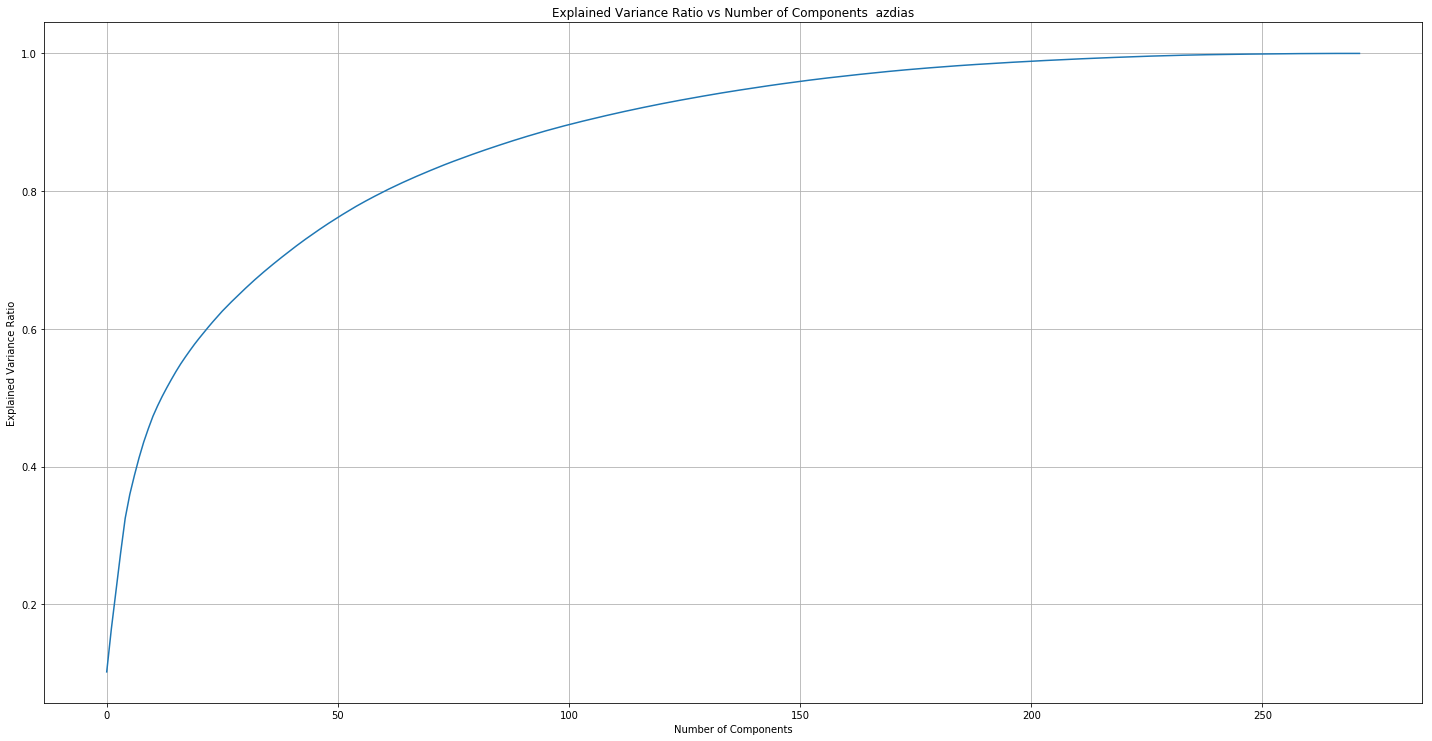

In [22]:
scree_plots(azdias_pca, ' azdias')

In the plot above we can see that 100 features explain 90% of the variance of the data

In [23]:
display_interesting_features(azdias_scaled, azdias_pca, 0,show=10)

Lowest: 
	D19_KONSUMTYP        -0.171
	CAMEO_DEUG_2015      -0.166
	D19_GESAMT_DATUM     -0.154
	PLZ8_ANTG3           -0.153
	PLZ8_BAUMAX          -0.147
	FINANZ_HAUSBAUER     -0.145
	PLZ8_ANTG4           -0.144
	CAMEO_DEU_2015       -0.143
	D19_VERSAND_DATUM    -0.141
	D19_GESAMT_ONLINE_DATUM -0.140
Highest: 
	KBA05_GBZ            0.148
	FINANZ_MINIMALIST    0.148
	income_category      0.149
	D19_VERSAND_ONLINE_QUOTE_12 0.150
	MOBI_REGIO           0.152
	D19_GESAMT_ONLINE_QUOTE_12 0.158
	KBA05_ANTG1          0.175
	wealth               0.197
	LP_STATUS_GROB       0.202
	LP_STATUS_FEIN       0.206


In [28]:
attributes['Attribute'].ffill(inplace=True)

In [36]:
attributes[(attributes['Attribute']=='LP_STATUS_GROB') | (attributes['Attribute']=='LP_STATUS_FEIN') | (attributes['Attribute']=='CAMEO_DEUG_2015')]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


These three features are about social status, or income... and since i already done some feature about it, i'll drop them

In [37]:
azdias_scaled = azdias_scaled.drop(['CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_STATUS_GROB'], axis=1)

In [38]:
with active_session():
    azdias_pca = pca_model(azdias_scaled, len(azdias_scaled.columns))

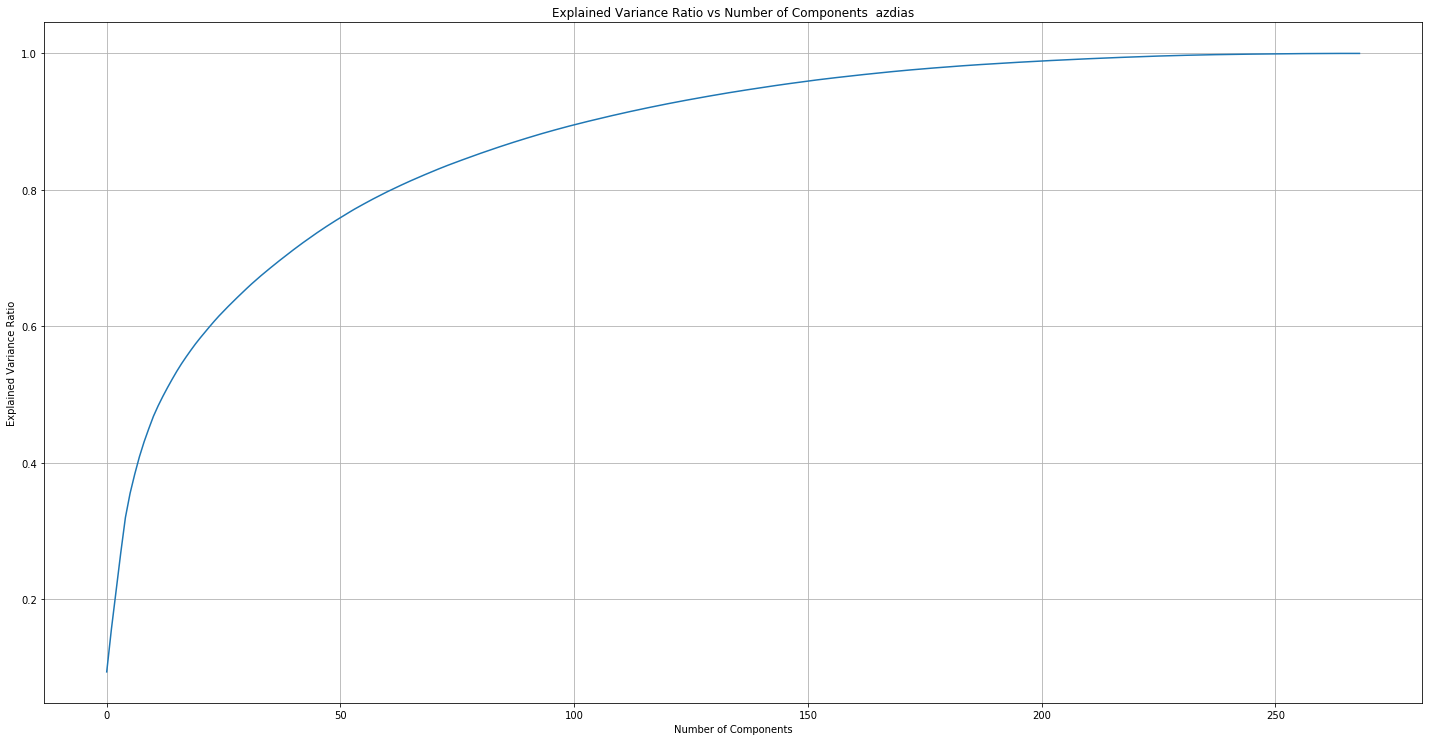

In [39]:
scree_plots(azdias_pca, ' azdias')

In [40]:
display_interesting_features(azdias_scaled, azdias_pca, 0,show=10)

Lowest: 
	D19_KONSUMTYP        -0.200
	D19_GESAMT_DATUM     -0.184
	D19_GESAMT_ONLINE_DATUM -0.170
	D19_VERSAND_DATUM    -0.168
	D19_VERSAND_ONLINE_DATUM -0.160
	PLZ8_ANTG3           -0.156
	PLZ8_BAUMAX          -0.147
	EWDICHTE             -0.144
	PLZ8_ANTG4           -0.143
	FINANZ_HAUSBAUER     -0.143
Highest: 
	income_category      0.140
	D19_GESAMT_ANZ_24    0.144
	GREEN_AVANTGARDE     0.145
	positioning          0.145
	KBA05_GBZ            0.147
	MOBI_REGIO           0.154
	KBA05_ANTG1          0.176
	D19_VERSAND_ONLINE_QUOTE_12 0.183
	D19_GESAMT_ONLINE_QUOTE_12 0.193
	wealth               0.197


In [54]:
# Take number of components that explain 80% of variance
cumsum = 0
for i,item in enumerate(azdias_pca.explained_variance_ratio_):
    cumsum += item
    if cumsum >= 0.8:
        print(f"{(i+1)} components explain 80% percent of the variance ratio.")
        break
    

62 components explain 80% percent of the variance ratio.


In [60]:
final_columns = azdias_scaled.columns
customers_adjusted = customers_adjusted[final_columns]
customers_adjusted.shape

(191652, 269)

## Preprocessing mail-order dataframe

In [92]:
%%time
with active_session():
    
    with open('selected_columns.pkl', 'rb') as f:
        selected_columns = pickle.load(f)
        
        
    mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
    print(f"Dataset Loaded")
    mailout_train_LNR_RESPONSE = mailout_train[['LNR','RESPONSE']].copy()
    mailout_train_clean = mailout_train.copy()
    mailout_train_clean = data_full_adjustment(mailout_train_clean)
    mailout_train_clean = mailout_train_clean[final_columns]

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


Dataset Loaded
Fixed Warning Columns
Setting only common attributes: OK!
Standardize Dataset Values: OK!
Wealth Feature, ok!
Family Feature, ok!
Neighborhood Feature, ok!
Community Feature, ok!
Gender Feature, ok!
Life Stage Feature, ok!
Income Feature, ok!
Positioning(Mainstream vs Avantgarde) Feature, ok!
Fixing birthdate attribute - replacing zeros to NaNs
Feature Engeneering: OK!
CPU times: user 4.65 s, sys: 449 ms, total: 5.1 s
Wall time: 7.02 s


In [93]:
%%time
with active_session():
    
    with open('selected_columns.pkl', 'rb') as f:
        selected_columns = pickle.load(f)
        
        
    mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
    print(f"Dataset Loaded")
    mailout_test_LNR = mailout_test['LNR'].copy()
    mailout_test_clean = mailout_test.copy()
    mailout_test_clean = data_full_adjustment(mailout_test_clean)
    mailout_test_clean = mailout_test_clean[final_columns]

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


Dataset Loaded
Fixed Warning Columns
Setting only common attributes: OK!
Standardize Dataset Values: OK!
Wealth Feature, ok!
Family Feature, ok!
Neighborhood Feature, ok!
Community Feature, ok!
Gender Feature, ok!
Life Stage Feature, ok!
Income Feature, ok!
Positioning(Mainstream vs Avantgarde) Feature, ok!
Fixing birthdate attribute - replacing zeros to NaNs
Feature Engeneering: OK!
CPU times: user 4.24 s, sys: 393 ms, total: 4.63 s
Wall time: 4.82 s


In [94]:
print(mailout_train_clean.shape)
print(mailout_test_clean.shape)

(42962, 269)
(42833, 269)


In [100]:
#Replacing NaNs with Azdias Modes in mail-order data
for column in final_columns:
    mode_value = azdias_adjusted[column].mode()[0]
    mailout_train_clean[column] = mailout_train_clean[column].replace(np.nan,mode_value)
    mailout_test_clean[column] = mailout_test_clean[column].replace(np.nan,mode_value)

## Using Pickle in DataFrames

In [103]:
with open('azdias_clean.pkl', 'wb') as f:
    pickle.dump(azdias_adjusted, f)

with open('customers_clean.pkl', 'wb') as f:
    pickle.dump(customers_adjusted, f)
    
with open('mailout_train_clean.pkl', 'wb') as f:
    pickle.dump(mailout_train_clean, f)
    
with open('mailout_test_clean.pkl', 'wb') as f:
    pickle.dump(mailout_test_clean, f)